# 아마존 세일즈 데이터 EDA - 가설 증명을 중심으로

## 1. 데이터 전처리

In [17]:
# Import Necessary Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import warnings

# from tqdm import tqdm_notebook
warnings.simplefilter(action='ignore')
%matplotlib inline

In [18]:
# Load the dataset (CSV File)
df = pd.read_csv('../../data/amazon.csv', encoding='utf-8')

def clean_price(price):
    return price.str.replace('₹', '').str.replace(',', '').astype('float64')

def clean_percentage(percentage):
    return percentage.str.rstrip('%').astype('float64') / 100

# Cleaning price columns
for col in ['discounted_price', 'actual_price']:
    df[col] = clean_price(df[col])

# Cleaning discount percentage
df['discount_percentage'] = clean_percentage(df['discount_percentage'])

# Changing Rating Columns Data Type
df['rating'] = df['rating'].str.replace('|', '3.9').astype('float64')

# Change Rating Count Columns Data Type
df['rating_count'] = clean_price(df['rating_count'])

In [33]:
# Drop image link, product link columns
df = df.drop(columns = ['img_link','product_link'], errors='ignore')

# Add Category column
df['big_category'] = df['category'].apply(lambda x: x.split('|')[0])

# Add item column
df['item'] = df['category'].apply(lambda x: x.split('|')[-1])

In [34]:
df_unique = df.drop_duplicates(subset='review_id', keep='first')

# Reset the index if needed
df_unique = df_unique.reset_index(drop=True)

# Display the first few rows and the shape of the new DataFrame
print(df_unique.head())
print(f"Shape of the DataFrame: {df_unique.shape}")

   product_id                                       product_name  \
0  B07JW9H4J1  Wayona Nylon Braided USB to Lightning Fast Cha...   
1  B098NS6PVG  Ambrane Unbreakable 60W / 3A Fast Charging 1.5...   
2  B096MSW6CT  Sounce Fast Phone Charging Cable & Data Sync U...   
3  B08HDJ86NZ  boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...   
4  B08CF3B7N1  Portronics Konnect L 1.2M Fast Charging 3A 8 P...   

                                            category  discounted_price  \
0  Computers&Accessories|Accessories&Peripherals|...             399.0   
1  Computers&Accessories|Accessories&Peripherals|...             199.0   
2  Computers&Accessories|Accessories&Peripherals|...             199.0   
3  Computers&Accessories|Accessories&Peripherals|...             329.0   
4  Computers&Accessories|Accessories&Peripherals|...             154.0   

   actual_price  discount_percentage  rating  rating_count  \
0        1099.0                 0.64     4.2       24269.0   
1         349.0       

In [35]:
def split_reviews(df):
    # List of columns to split
    split_columns = ['user_id', 'user_name', 'review_id', 'review_title', 'review_content']
    
    # Function to split a row
    def split_row(row):
        # (1) Split the values for each column
        split_values = [row[col].split(',') for col in split_columns]
        
        # (2) Determine the number of splits based on user_id or review_id
        num_splits = max(len(row['user_id'].split(',')), len(row['review_id'].split(',')))
        
        # (3) Create new rows
        new_rows = []
        for i in range(num_splits):
            new_row = row.copy()
            for col, values in zip(split_columns, split_values):
                new_row[col] = values[i] if i < len(values) else values[-1]
            new_rows.append(new_row)
        
        return pd.DataFrame(new_rows)

    # Apply the split_row function to each row and concatenate the results
    return pd.concat([split_row(row) for _, row in df.iterrows()], ignore_index=True)

# Apply the function to split the reviews
df_split = split_reviews(df_unique)

# Display the result
print("====== Before Split ======")
print(df_unique['review_content'].head(5))
print("====== After Split ======")
print(df_split['review_content'].head(5))

# Optionally, save the result to a new CSV file
# df_split.to_csv('split_reviews.csv', index=False)

====== Before Split ======
0    Looks durable Charging is fine tooNo complains...
1    I ordered this cable to connect my phone to An...
2    Not quite durable and sturdy,https://m.media-a...
3    Good product,long wire,Charges good,Nice,I bou...
4    Bought this instead of original apple, does th...
Name: review_content, dtype: object
====== After Split ======
0       Looks durable Charging is fine tooNo complains
1                              Charging is really fast
2                                        good product.
3                 Till now satisfied with the quality.
4    This is a good product . The charging speed is...
Name: review_content, dtype: object


In [36]:
df_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9364 entries, 0 to 9363
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           9364 non-null   object 
 1   product_name         9364 non-null   object 
 2   category             9364 non-null   object 
 3   discounted_price     9364 non-null   float64
 4   actual_price         9364 non-null   float64
 5   discount_percentage  9364 non-null   float64
 6   rating               9364 non-null   float64
 7   rating_count         9362 non-null   float64
 8   about_product        9364 non-null   object 
 9   user_id              9364 non-null   object 
 10  user_name            9364 non-null   object 
 11  review_id            9364 non-null   object 
 12  review_title         9364 non-null   object 
 13  review_content       9364 non-null   object 
 14  big_category         9364 non-null   object 
 15  item                 9364 non-null   o

In [40]:
num_category = len(df['big_category'].unique())
num_item = len(df['item'].unique())
print("There are %d categories, and %d items"%(num_category, num_item))

There are 9 categories, and 207 items


In [50]:
# 카테고리 별 데이터 개수 체크
big_category_count = df.groupby('big_category').size().reset_index(name='count')
big_category_count.sort_values('count', ascending=False, inplace=True)
big_category_count

,big_category,count
2,Electronics,526
1,Computers&Accessories,453
4,Home&Kitchen,448
7,OfficeProducts,31
5,HomeImprovement,2
6,MusicalInstruments,2
0,Car&Motorbike,1
3,Health&PersonalCare,1
8,Toys&Games,1


In [61]:
# 아이템 별 데이터 개수 체크 (상위 20개)
item_count = df.groupby('item').size().reset_index(name='count')
item_count.sort_values('count', ascending=False, inplace=True)
item_count.head(20)

,item,count
189,USBCables,233
162,SmartWatches,76
163,Smartphones,68
161,SmartTelevisions,63
80,In-Ear,52
141,RemoteControls,49
109,MixerGrinders,27
67,HDMICables,24
105,Mice,24
42,DryIrons,24


## 3. 제품별 가격 & 할인율 분석

### (1) 전반적인 가격 & 할인율 분포
- '스마트'제품들의 가격대가 전반적으로 높은 편임, 그 뒤를 주방 용품이 잇고 있음.
- <span style="color: #1e90ff;">스마트워치</span>의 할인율이 가장 높으며, 그 다음으로 인이어 이어폰, 각종 케이블, 리모콘 및 가전 제품들이 이어짐.

### (2) 제품별 분석
#### USB 케이블
- 가격 상승에 따라 할인율 증가 후 **특정 가격대에서 정점** 도달
- '피크'는 <span style="color: #ffa500;">최적의 할인 지점</span>을 나타냄

#### 스마트워치
- 가격과 할인율 사이 **복잡한 비선형 관계** 존재
- 중간 가격대에서 할인율 감소, **고가 제품에서 크게 증가**
- <span style="color: #ffa500;">고가 제품에 대한 공격적 할인 정책</span> 시사

#### 스마트폰
- 대부분 가격대에서 **할인율 일정**
- <span style="color: #ffa500;">최고가 제품에서 할인율 급증</span>
- 프리미엄 모델 특별 프로모션 전략 가능성

#### 스마트 TV
- 가격 상승에 따라 할인율 소폭 감소
- 최고가 제품에서 **할인율 다시 증가**

#### 주의해야 할 추세
1. **비선형성**: 대부분 제품에서 가격-할인율 관계 복잡
2. **고가 제품 할인**: <span style="color: #ffa500;">최고가 제품들의 할인율 증가 경향</span>
3. **제품별 차이**: 각 카테고리마다 상이한 할인 패턴
4. **데이터 집중도**: 특정 가격대 데이터 포인트 집중

> 이러한 분석을 토대로 **각 제품 카테고리별 맞춤형 가격 및 할인 전략** 수립 가능할지도?

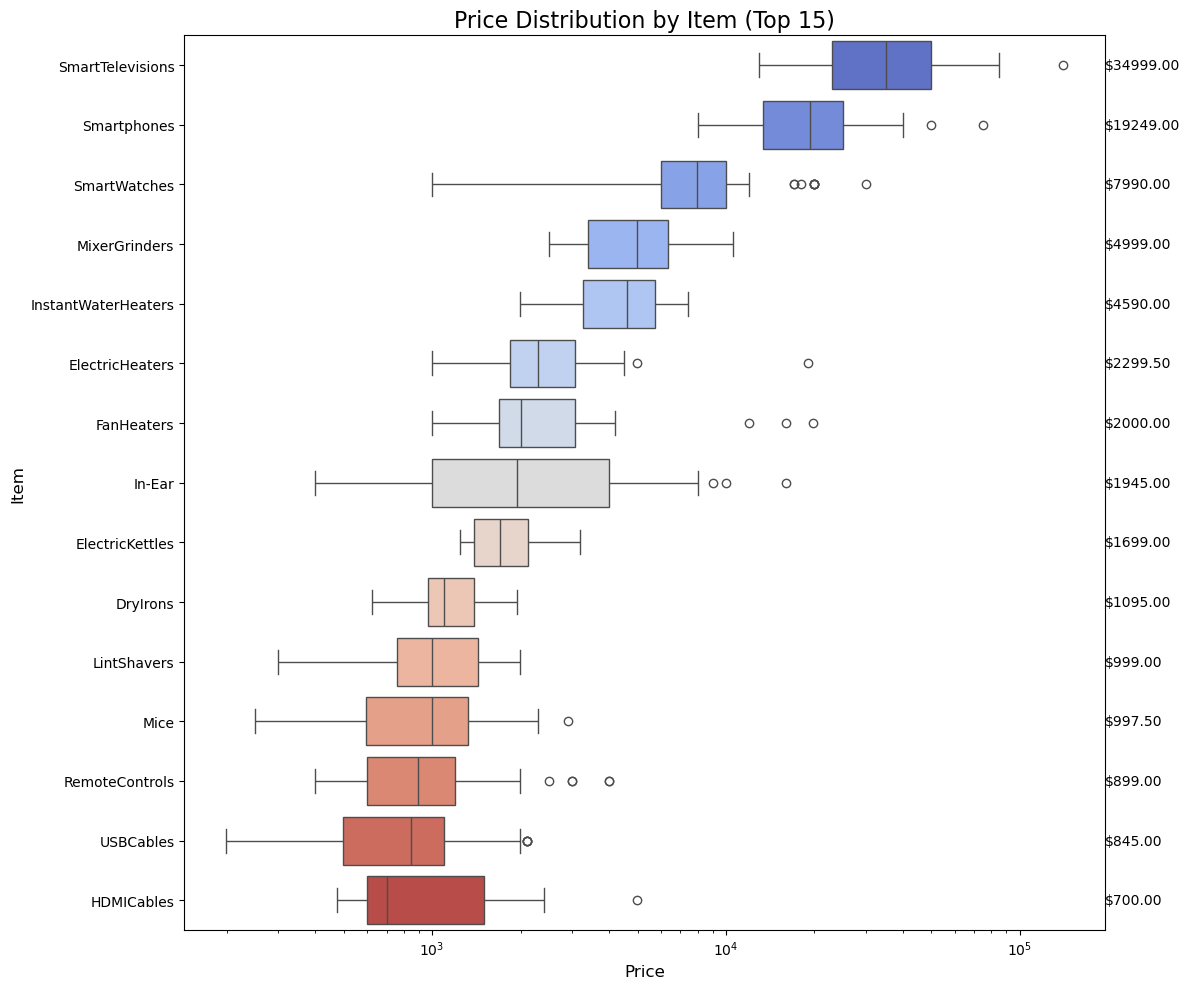

In [58]:
# Filter the DataFrame to include only these top items
top_items = df['item'].value_counts().nlargest(15).index
df_top = df[df['item'].isin(top_items)]
df_top['discount_percentage'] *= 100

# Calculate median prices for sorting and color coding
median_prices = df_top.groupby('item')['actual_price'].median().sort_values(ascending=False)

# Create the plot
plt.figure(figsize=(12, 10))

# Create box plot
sns.boxplot(x='actual_price', y='item', data=df_top, 
            order=median_prices.index, 
            palette=sns.color_palette("coolwarm", n_colors=len(top_items)))

# Customize the plot
plt.title('Price Distribution by Item (Top 15)', fontsize=16)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Item', fontsize=12)
plt.xscale('log')  # Use log scale for price to handle wide range

# Add median price labels
for i, item in enumerate(median_prices.index):
    median_price = median_prices[item]
    plt.text(plt.xlim()[1], i, f'${median_price:.2f}', 
             verticalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()

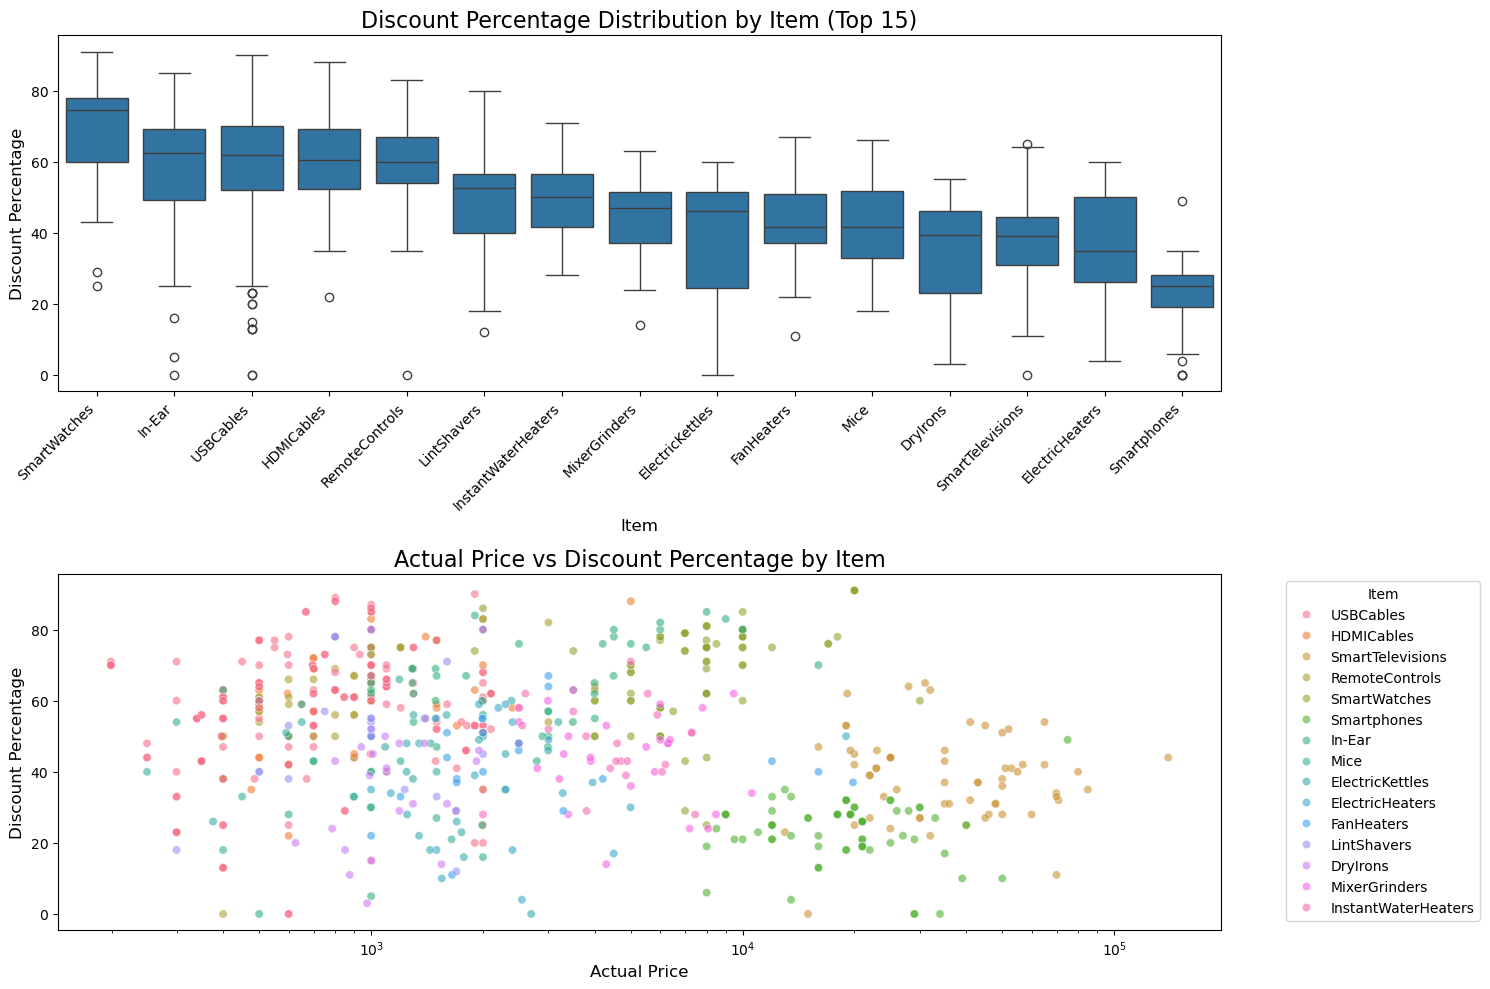

Average Discount Percentage by Item:
item
SmartWatches           69.815789
HDMICables             59.791667
RemoteControls         59.510204
USBCables              59.377682
In-Ear                 58.269231
LintShavers            51.318182
InstantWaterHeaters    48.043478
MixerGrinders          43.962963
FanHeaters             42.450000
Mice                   42.041667
ElectricKettles        39.000000
SmartTelevisions       38.285714
ElectricHeaters        36.000000
DryIrons               34.250000
Smartphones            23.294118
Name: discount_percentage, dtype: float64

Correlation between Actual Price and Discount Percentage: -0.28


In [69]:
# Filter the DataFrame to include only these top items
top_items = df['item'].value_counts().nlargest(15).index
df_top = df[df['item'].isin(top_items)]
df_top['discount_percentage'] *= 100

# Create the plot
plt.figure(figsize=(15, 10))

# 1. Boxplot of discount percentages by item
plt.subplot(2, 1, 1)
sns.boxplot(x='item', y='discount_percentage', data=df_top, 
            order=df_top.groupby('item')['discount_percentage'].median().sort_values(ascending=False).index)
plt.title('Discount Percentage Distribution by Item (Top 15)', fontsize=16)
plt.xlabel('Item', fontsize=12)
plt.ylabel('Discount Percentage', fontsize=12)
plt.xticks(rotation=45, ha='right')

# 2. Scatter plot of actual price vs discount percentage
plt.subplot(2, 1, 2)
sns.scatterplot(x='actual_price', y='discount_percentage', hue='item', data=df_top, alpha=0.6)
plt.title('Actual Price vs Discount Percentage by Item', fontsize=16)
plt.xlabel('Actual Price', fontsize=12)
plt.ylabel('Discount Percentage', fontsize=12)
plt.xscale('log')  # Use log scale for price to handle wide range
plt.legend(title='Item', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Calculate average discount percentage for each item
avg_discount = df_top.groupby('item')['discount_percentage'].mean().sort_values(ascending=False)
print("Average Discount Percentage by Item:")
print(avg_discount)

# Calculate correlation between actual price and discount percentage
correlation = df_top['actual_price'].corr(df_top['discount_percentage'])
print(f"\nCorrelation between Actual Price and Discount Percentage: {correlation:.2f}")

In [72]:
! pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 10.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 4.8 MB/s eta 0:00:00ta 0:00:01


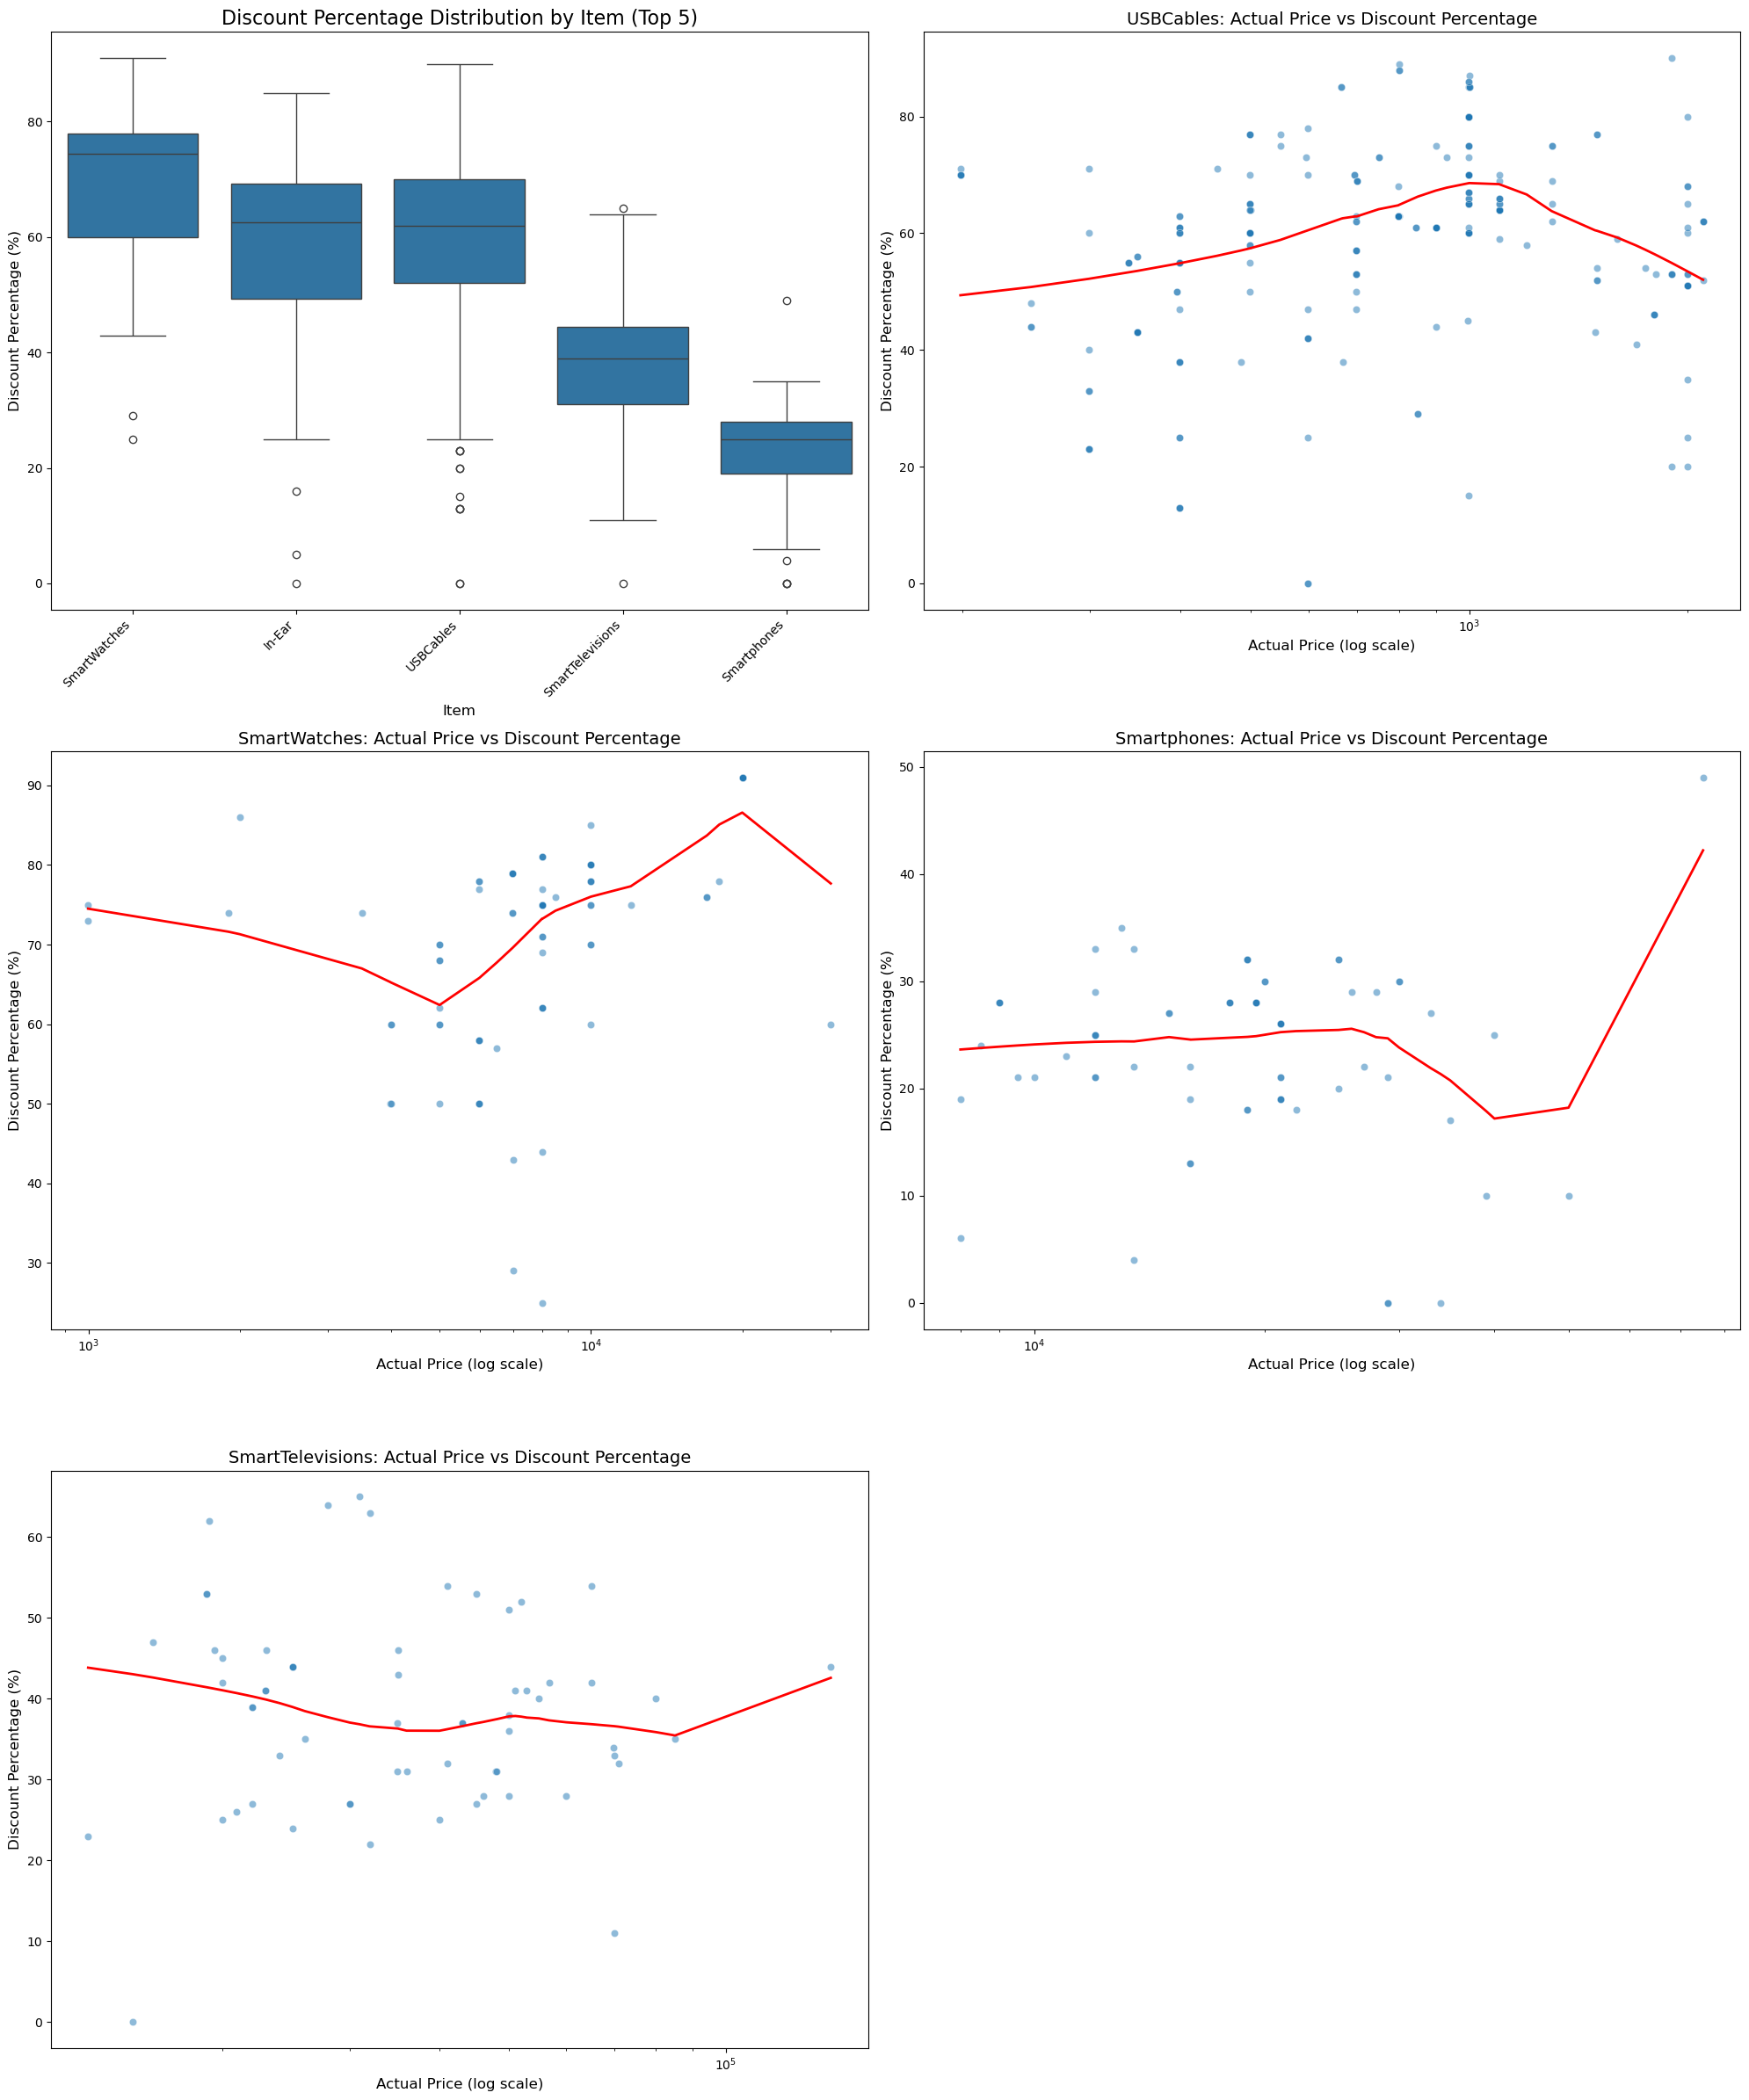

Average Discount Percentage by Item:
item
SmartWatches        69.815789
USBCables           59.377682
In-Ear              58.269231
SmartTelevisions    38.285714
Smartphones         23.294118
Name: discount_percentage, dtype: float64

Correlation between Actual Price and Discount Percentage for USBCables: 0.09 (p-value: 0.1788)

Correlation between Actual Price and Discount Percentage for SmartWatches: 0.36 (p-value: 0.0016)

Correlation between Actual Price and Discount Percentage for Smartphones: 0.04 (p-value: 0.7341)

Correlation between Actual Price and Discount Percentage for SmartTelevisions: -0.03 (p-value: 0.8028)

Correlation between Actual Price and Discount Percentage for In-Ear: 0.48 (p-value: 0.0004)


In [73]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Filter the DataFrame to include only these top items
top_items = df['item'].value_counts().nlargest(5).index
df_top = df[df['item'].isin(top_items)]
df_top['discount_percentage'] *= 100

# Assuming your DataFrame is named 'df'
# Let's focus on the top 5 items by count
top_items = df['item'].value_counts().nlargest(5).index
df_top = df[df['item'].isin(top_items)]

# Convert discount percentage to actual percentage (0-100 range)
df_top['discount_percentage'] *= 100

# Create the plots
fig, axes = plt.subplots(3, 2, figsize=(20, 24))
axes = axes.flatten()  # Flatten the 2D array of axes to make it easier to iterate

# 1. Boxplot of discount percentages by item
sns.boxplot(x='item', y='discount_percentage', data=df_top, ax=axes[0],
            order=df_top.groupby('item')['discount_percentage'].median().sort_values(ascending=False).index)
axes[0].set_title('Discount Percentage Distribution by Item (Top 5)', fontsize=16)
axes[0].set_xlabel('Item', fontsize=12)
axes[0].set_ylabel('Discount Percentage (%)', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# 2. Individual scatter plots for each item
for i, item in enumerate(top_items, start=1):
    item_data = df_top[df_top['item'] == item]
    sns.scatterplot(x='actual_price', y='discount_percentage', data=item_data, ax=axes[i], alpha=0.5)
    
    # Add LOWESS trend line
    x = item_data['actual_price']
    y = item_data['discount_percentage']
    lowess_result = lowess(y, x, frac=0.6)
    axes[i].plot(lowess_result[:, 0], lowess_result[:, 1], color='red', linewidth=2)
    
    axes[i].set_xscale('log')
    axes[i].set_title(f'{item}: Actual Price vs Discount Percentage', fontsize=14)
    axes[i].set_xlabel('Actual Price (log scale)', fontsize=12)
    axes[i].set_ylabel('Discount Percentage (%)', fontsize=12)

# Remove the extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

# Calculate average discount percentage for each item
avg_discount = df_top.groupby('item')['discount_percentage'].mean().sort_values(ascending=False)
print("Average Discount Percentage by Item:")
print(avg_discount)

# Calculate correlation between actual price and discount percentage for each item
for item in top_items:
    item_data = df_top[df_top['item'] == item]
    correlation, p_value = sp.stats.pearsonr(item_data['actual_price'], item_data['discount_percentage'])
    print(f"\nCorrelation between Actual Price and Discount Percentage for {item}: {correlation:.2f} (p-value: {p_value:.4f})")

### (3) 카테고리 X 제품 X 평점 X 가격 분석
> 각 'big_category' 내에서 주요 'item'들을 선별하여 개별적인 버블 차트 생성. 특정 제품 유형의 가격-평점-리뷰 수 관계를 더 명확히 파악 가능.


#### Electronics:
- SmartWatches: 가격 범위가 넓고, 평점도 다양함. 리뷰 수가 많은 제품들이 많아 인기 있는 카테고리로 보임.
- Smartphones: 고가 제품이 많으며, 대체로 높은 평점을 받음. 리뷰 수도 상당히 많음.
- SmartTelevisions: 가장 고가 제품군이며, 평점은 대체로 높은 편임.
- In-Ear: 중저가 제품이 많고, 평점 분포가 넓음.
- RemoteControls: 저가 제품군이며, 평점은 중상위권임.


#### Computers&Accessories:
- USBCables: 저가 제품이 주를 이루며, 평점 분포가 넓음.
- Lapdesks: 중저가 제품이 많고, 평점은 대체로 높은 편임.
- Mice: 가격대가 다양하고, 평점도 비교적 고르게 분포됨.
- WirelessUSBAdapters: 저가에서 중가 사이에 분포하며, 평점은 중상위권임.
- GraphicTablets: 중고가 제품이 많고, 평점이 대체로 높음.


#### Home&Kitchen:
- MixerGrinders: 중저가 제품이 주를 이루며, 평점 분포가 넓음.
- LintShavers: 저가 제품군이고, 평점은 중상위권임. (보풀 제거기)
- DryIrons: 저가에서 중가 사이에 분포하며, 평점 분포가 넓음.
- InstantWaterHeaters: 중고가 제품이 많고, 평점은 대체로 높은 편임.
- ElectricHeaters: 중가 제품이 주를 이루며, 평점은 중상위권임.



#### 전반적인 관찰:
- 각 카테고리마다 가격대와 평점 분포가 상이하며 대체로 고가 제품일수록 평점이 높은 경향이 있으나, 예외도 존재함.
- 리뷰 수(버블 크기)를 제품의 인기도로 해석할 때, 각 카테고리마다 인기 제품군이 다름. (제품 별 브랜드를 알 수 있었으면 더 좋았을 것으로 사료됨.)
- Electronics 카테고리가 전반적으로 가격대가 높고 리뷰 수도 많은 편임.
- Home&Kitchen 제품들은 대체로 중저가 제품이 많고, 평점 분포가 넓은 편임.

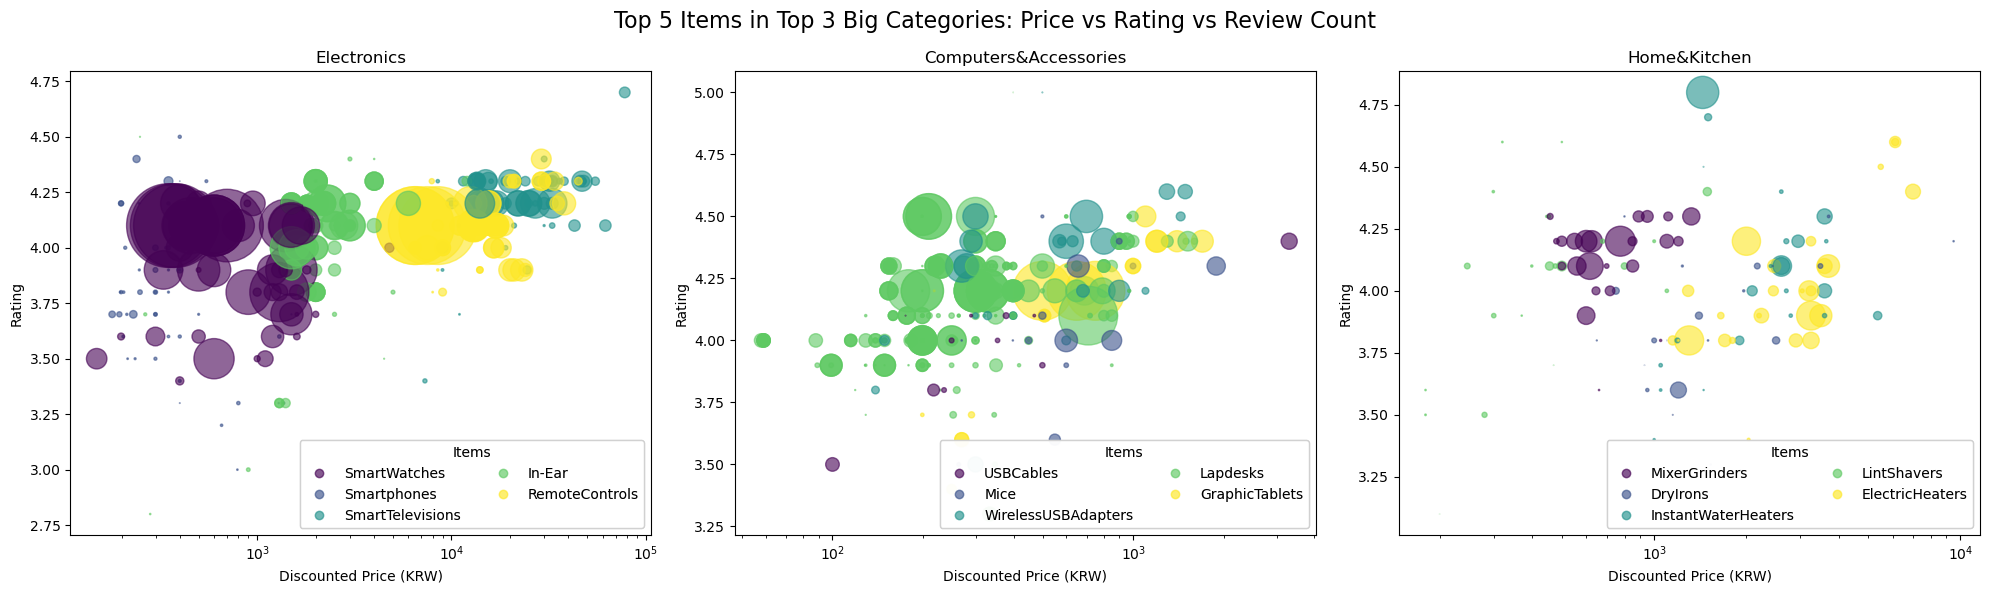


Electronics - Top 5 Items Summary:
                  discounted_price  rating  rating_count
item                                                    
In-Ear                      976.17    3.90      80864.21
RemoteControls              438.94    3.80        703.78
SmartTelevisions          24840.19    4.21      12067.92
SmartWatches               2339.70    4.02      21637.84
Smartphones               15754.44    4.10      36665.72

Computers&Accessories - Top 5 Items Summary:
                     discounted_price  rating  rating_count
item                                                       
GraphicTablets                 569.82    3.98       3450.73
Lapdesks                       672.57    4.06       7655.50
Mice                           609.33    4.29      16970.38
USBCables                      360.72    4.15      15358.51
WirelessUSBAdapters            722.11    4.09      40395.17

Home&Kitchen - Top 5 Items Summary:
                     discounted_price  rating  rating_count
it

In [82]:
# 상위 3개 big_category 선택
top_categories = df['big_category'].value_counts().nlargest(3).index

# 플롯 설정
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Top 5 Items in Top 3 Big Categories: Price vs Rating vs Review Count', fontsize=16)

for idx, category in enumerate(top_categories):
    # 해당 카테고리의 데이터만 선택
    category_data = df[df['big_category'] == category]
    
    # 상위 5개 아이템 선택
    top_items = category_data['item'].value_counts().nlargest(5).index
    plot_data = category_data[category_data['item'].isin(top_items)]

    # 버블 차트 그리기
    scatter = axes[idx].scatter(
        x='discounted_price',
        y='rating',
        s=plot_data['rating_count'] / 100,  # 버블 크기 조정
        alpha=0.6,
        c=plot_data['item'].astype('category').cat.codes,  # 색상
        data=plot_data
    )

    # 차트 설정
    axes[idx].set_title(f'{category}')
    axes[idx].set_xlabel('Discounted Price (KRW)')
    axes[idx].set_ylabel('Rating')
    axes[idx].set_xscale('log')  # x축 로그 스케일

    # 범례 추가
    legend1 = axes[idx].legend(scatter.legend_elements()[0], top_items, ncol=2,
                               loc="lower right", title="Items")
    axes[idx].add_artist(legend1)

    # # 버블 크기에 대한 범례 추가
    # kw = dict(prop="sizes", num=3, color=scatter.cmap(0.7), fmt=":{x:.0f}",
    #           func=lambda s: s*100)  # s*100 to reverse the /100 scaling
    # legend2 = axes[idx].legend(*scatter.legend_elements(**kw), 
    #                            loc="lower right", title="Review Count")
    # axes[idx].add_artist(legend2)

plt.tight_layout()
plt.show()

# 각 카테고리별 상위 5개 아이템의 평균 가격, 평점, 리뷰 수 출력
for category in top_categories:
    category_data = df[df['big_category'] == category]
    top_items = category_data['item'].value_counts().nlargest(5).index
    summary = category_data[category_data['item'].isin(top_items)].groupby('item').agg({
        'discounted_price': 'mean',
        'rating': 'mean',
        'rating_count': 'mean'
    }).round(2)
    print(f"\n{category} - Top 5 Items Summary:")
    print(summary)

## 4. 가격 <span style="color: #ffa500;">구간 별 성과</span> 분석
> 어떤 가격대의 제품이 소비자들에게 <span style="color: #ffa500;">가장 호응이 좋은지 파악</span>하려는 의도로, 
> 가격을 몇 개의 구간으로 나누고, 각 구간 내 아이템들의 <span style="color: #ffa500;">평균 평점과 리뷰 수</span> 계산

#### (1) 가격과 평점의 관계
- 가격이 높아질수록 평균 평점이 약간 상승하는 경향이 있음
- '매우 높음' 가격대에서 평균 평점이 4.15로 가장 높음
- 가격과 만족도 간의 차이는 크지 않음 (4.05에서 4.15 사이)

#### (2) 가격과 리뷰 수의 관계
- 중간 가격대(Low, Medium, High)에서 리뷰 수가 가장 많음
- 최저가와 최고가 제품은 리뷰 수가 상대적으로 적음
- 중간 가격대 제품이 가장 많이 판매되거나 리뷰 참여도가 높은 것으로 추정됨

#### (3) 상관관계 분석
- 가격과 평점: 약한 양의 상관관계 (0.12)
- 가격과 리뷰 수: 거의 상관관계 없음 (-0.03)
- 평점과 리뷰 수: 약한 양의 상관관계 (0.10)

#### (4) 가격대별 주요 제품
- 저가: HDMI 케이블, 이어폰, 마우스
- 중가: MicroSD 카드, USB 메모리, 블루투스 어댑터
- 고가: 외장 하드디스크, 돔 카메라, SSD
> 각 가격대마다 인기 있는 제품 카테고리가 다름: 저가는 주변기기, 중가는 저장장치, 고가는 전문 전자기기가 주를 이룸

#### 결론 및 시사점
1. 높은 가격이 반드시 높은 만족도나 많은 리뷰를 보장하지 않음
2. 중간 가격대 제품들이 가장 활발한 소비자 참여를 유도함
3. 가격대별로 인기 있는 제품 카테고리가 다르며, 이는 각 가격대에 적합한 제품 특성이 있음을 시사함

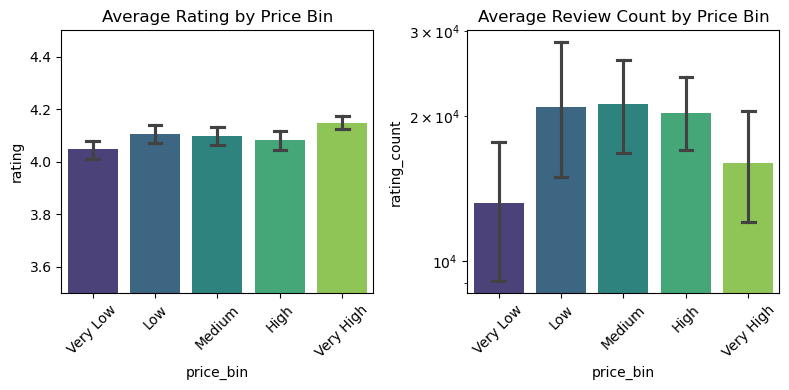

Price Bin Performance:
          discounted_price           rating       rating_count          
                      mean       std   mean   std         mean       std
price_bin                                                               
Very Low            180.28     58.28   4.05  0.31     13174.33  40867.07
Low                 384.47     72.54   4.11  0.30     20846.88  56864.63
Medium              844.73    203.84   4.10  0.31     21157.18  42144.32
High               1786.62    402.43   4.08  0.30     20327.64  31627.21
Very High         12475.03  11420.52   4.15  0.22     16004.66  37675.26

Correlation between Price, Rating, and Review Count:
                  discounted_price  rating  rating_count
discounted_price              1.00    0.12         -0.03
rating                        0.12    1.00          0.10
rating_count                 -0.03    0.10          1.00

Top 3 Items in Very Low:
            discounted_price  rating  rating_count
item                              

In [104]:
# 1. 가격 구간 생성 q개 구간)
# df['price_bin'] = pd.qcut(df['discounted_price'], q=10, labels=[f'Bin {i+1}' for i in range(10)]) # 10개
df['price_bin'] = pd.qcut(np.log1p(df['discounted_price']), q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']) # 5개

# 2. 가격 구간별 성과 계산
performance = df.groupby('price_bin').agg({
    'discounted_price': ['mean', 'std'],
    'rating': ['mean', 'std'],
    'rating_count': ['mean', 'std']
})

# 3. 상관관계 분석
correlation = df[['discounted_price', 'rating', 'rating_count']].corr()

# 4. 카테고리별 분석 준비
category_performance = df.groupby(['big_category', 'price_bin']).agg({
    'rating': 'mean',
    'rating_count': 'mean'
}).reset_index()

# 데이터 시각화
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# 1. 가격 구간별 평균 평점 및 리뷰 수 (오차 막대 포함)
sns.barplot(x='price_bin', y='rating', data=df, ax=axes[0], capsize=.2, palette='viridis')
axes[0].set_title('Average Rating by Price Bin')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_ylim(3.5, 4.5)  # Adjust y-axis for better visibility of differences

sns.barplot(x='price_bin', y='rating_count', data=df, ax=axes[1], capsize=.2, palette='viridis')
axes[1].set_title('Average Review Count by Price Bin')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_yscale('log')  # 로그 스케일 적용

# # 2. 히트맵: 가격, 평점, 리뷰 수의 상관관계
# sns.heatmap(correlation, annot=True, cmap='coolwarm', ax=axes[1,0])
# axes[1,0].set_title('Correlation Heatmap')

# # 3. 카테고리별 가격-평점 관계
# for category in df['big_category'].unique():
#     category_data = category_performance[category_performance['big_category'] == category]
#     axes[1,1].plot(category_data['price_bin'], category_data['rating'], label=category)

# axes[1,1].set_title('Average Rating by Price Bin for Each Category')
# axes[1,1].legend(title='Category')
# axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45)
# axes[1,1].set_ylim(3.5, 4.5)  # Adjust y-axis for better visibility of differences

plt.tight_layout()
plt.show()

# 추가 분석 결과 출력
print("Price Bin Performance:")
print(performance.round(2))

print("\nCorrelation between Price, Rating, and Review Count:")
print(correlation.round(2))

# 가격 구간별 상위 아이템 출력
for bin in performance.index:
    print(f"\nTop 3 Items in {bin}:")
    top_items = df[df['price_bin'] == bin].groupby('item').agg({
        'discounted_price': 'mean',
        'rating': 'mean',
        'rating_count': 'mean'
    }).sort_values('rating_count', ascending=False).head(3).round(2)
    print(top_items)

## 5. 경쟁 제품 분석
> 같은 카테고리 내에서 <span style="color: #ffa500;">경쟁 관계</span>에 있는 아이템들을 비교 분석.
> 가격 대비 평점, 리뷰 수 등을 비교하여 각 제품의 시장 위치 파악.

In [106]:
def shorten_product_name(name):
    # 제품명을 브랜드와 모델명으로 축약
    parts = name.split()
    return ' '.join(parts[:3])  # 처음 3단어만 사용

In [107]:
def analyze_competitive_products(df, category, n_top_items=5):
    # 해당 카테고리의 상위 n개 아이템 선택
    category_data = df[df['item'] == category]
    top_items = category_data['product_name'].value_counts().nlargest(n_top_items).index
    
    # 선택된 아이템들의 데이터 추출
    competitive_data = category_data[category_data['product_name'].isin(top_items)]
    
    # 각 제품별 평균 가격, 평점, 리뷰 수 계산
    product_summary = competitive_data.groupby('product_name').agg({
        'discounted_price': 'mean',
        'rating': 'mean',
        'rating_count': 'mean'
    }).round(2)
    
    # 가격 대비 평점 및 리뷰 수 계산
    product_summary['rating_per_price'] = (product_summary['rating'] / product_summary['discounted_price']) * 1000
    product_summary['reviews_per_price'] = product_summary['rating_count'] / product_summary['discounted_price']
    
    # 제품명 축약
    product_summary.index = product_summary.index.map(shorten_product_name)

    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    fig.suptitle(f'Competitive Analysis for {category}', fontsize=16)
    
    # 가격 vs 평점
    sns.scatterplot(x='discounted_price', y='rating', size='rating_count', 
                    data=product_summary, ax=axes[0,0])
    for idx, row in product_summary.iterrows():
        axes[0,0].annotate(idx, (row['discounted_price'], row['rating']))
    axes[0,0].set_title('Price vs Rating')
    
    # 가격 vs 리뷰 수
    sns.scatterplot(x='discounted_price', y='rating_count', size='rating', 
                    data=product_summary, ax=axes[0,1])
    for idx, row in product_summary.iterrows():
        axes[0,1].annotate(idx, (row['discounted_price'], row['rating_count']))
    axes[0,1].set_title('Price vs Review Count')
    
    # 가격 대비 평점
    sns.barplot(x=product_summary.index, y='rating_per_price', data=product_summary, ax=axes[1,0])
    axes[1,0].set_title('Rating per Price (Normalized)')
    axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=90, ha='right')
    
    # 가격 대비 리뷰 수
    sns.barplot(x=product_summary.index, y='reviews_per_price', data=product_summary, ax=axes[1,1])
    axes[1,1].set_title('Reviews per Price')
    axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=90, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    return product_summary

In [113]:
item_count.head(5)

,item,count
189,USBCables,233
162,SmartWatches,76
163,Smartphones,68
161,SmartTelevisions,63
80,In-Ear,52


### 스마트폰 카테고리 분석

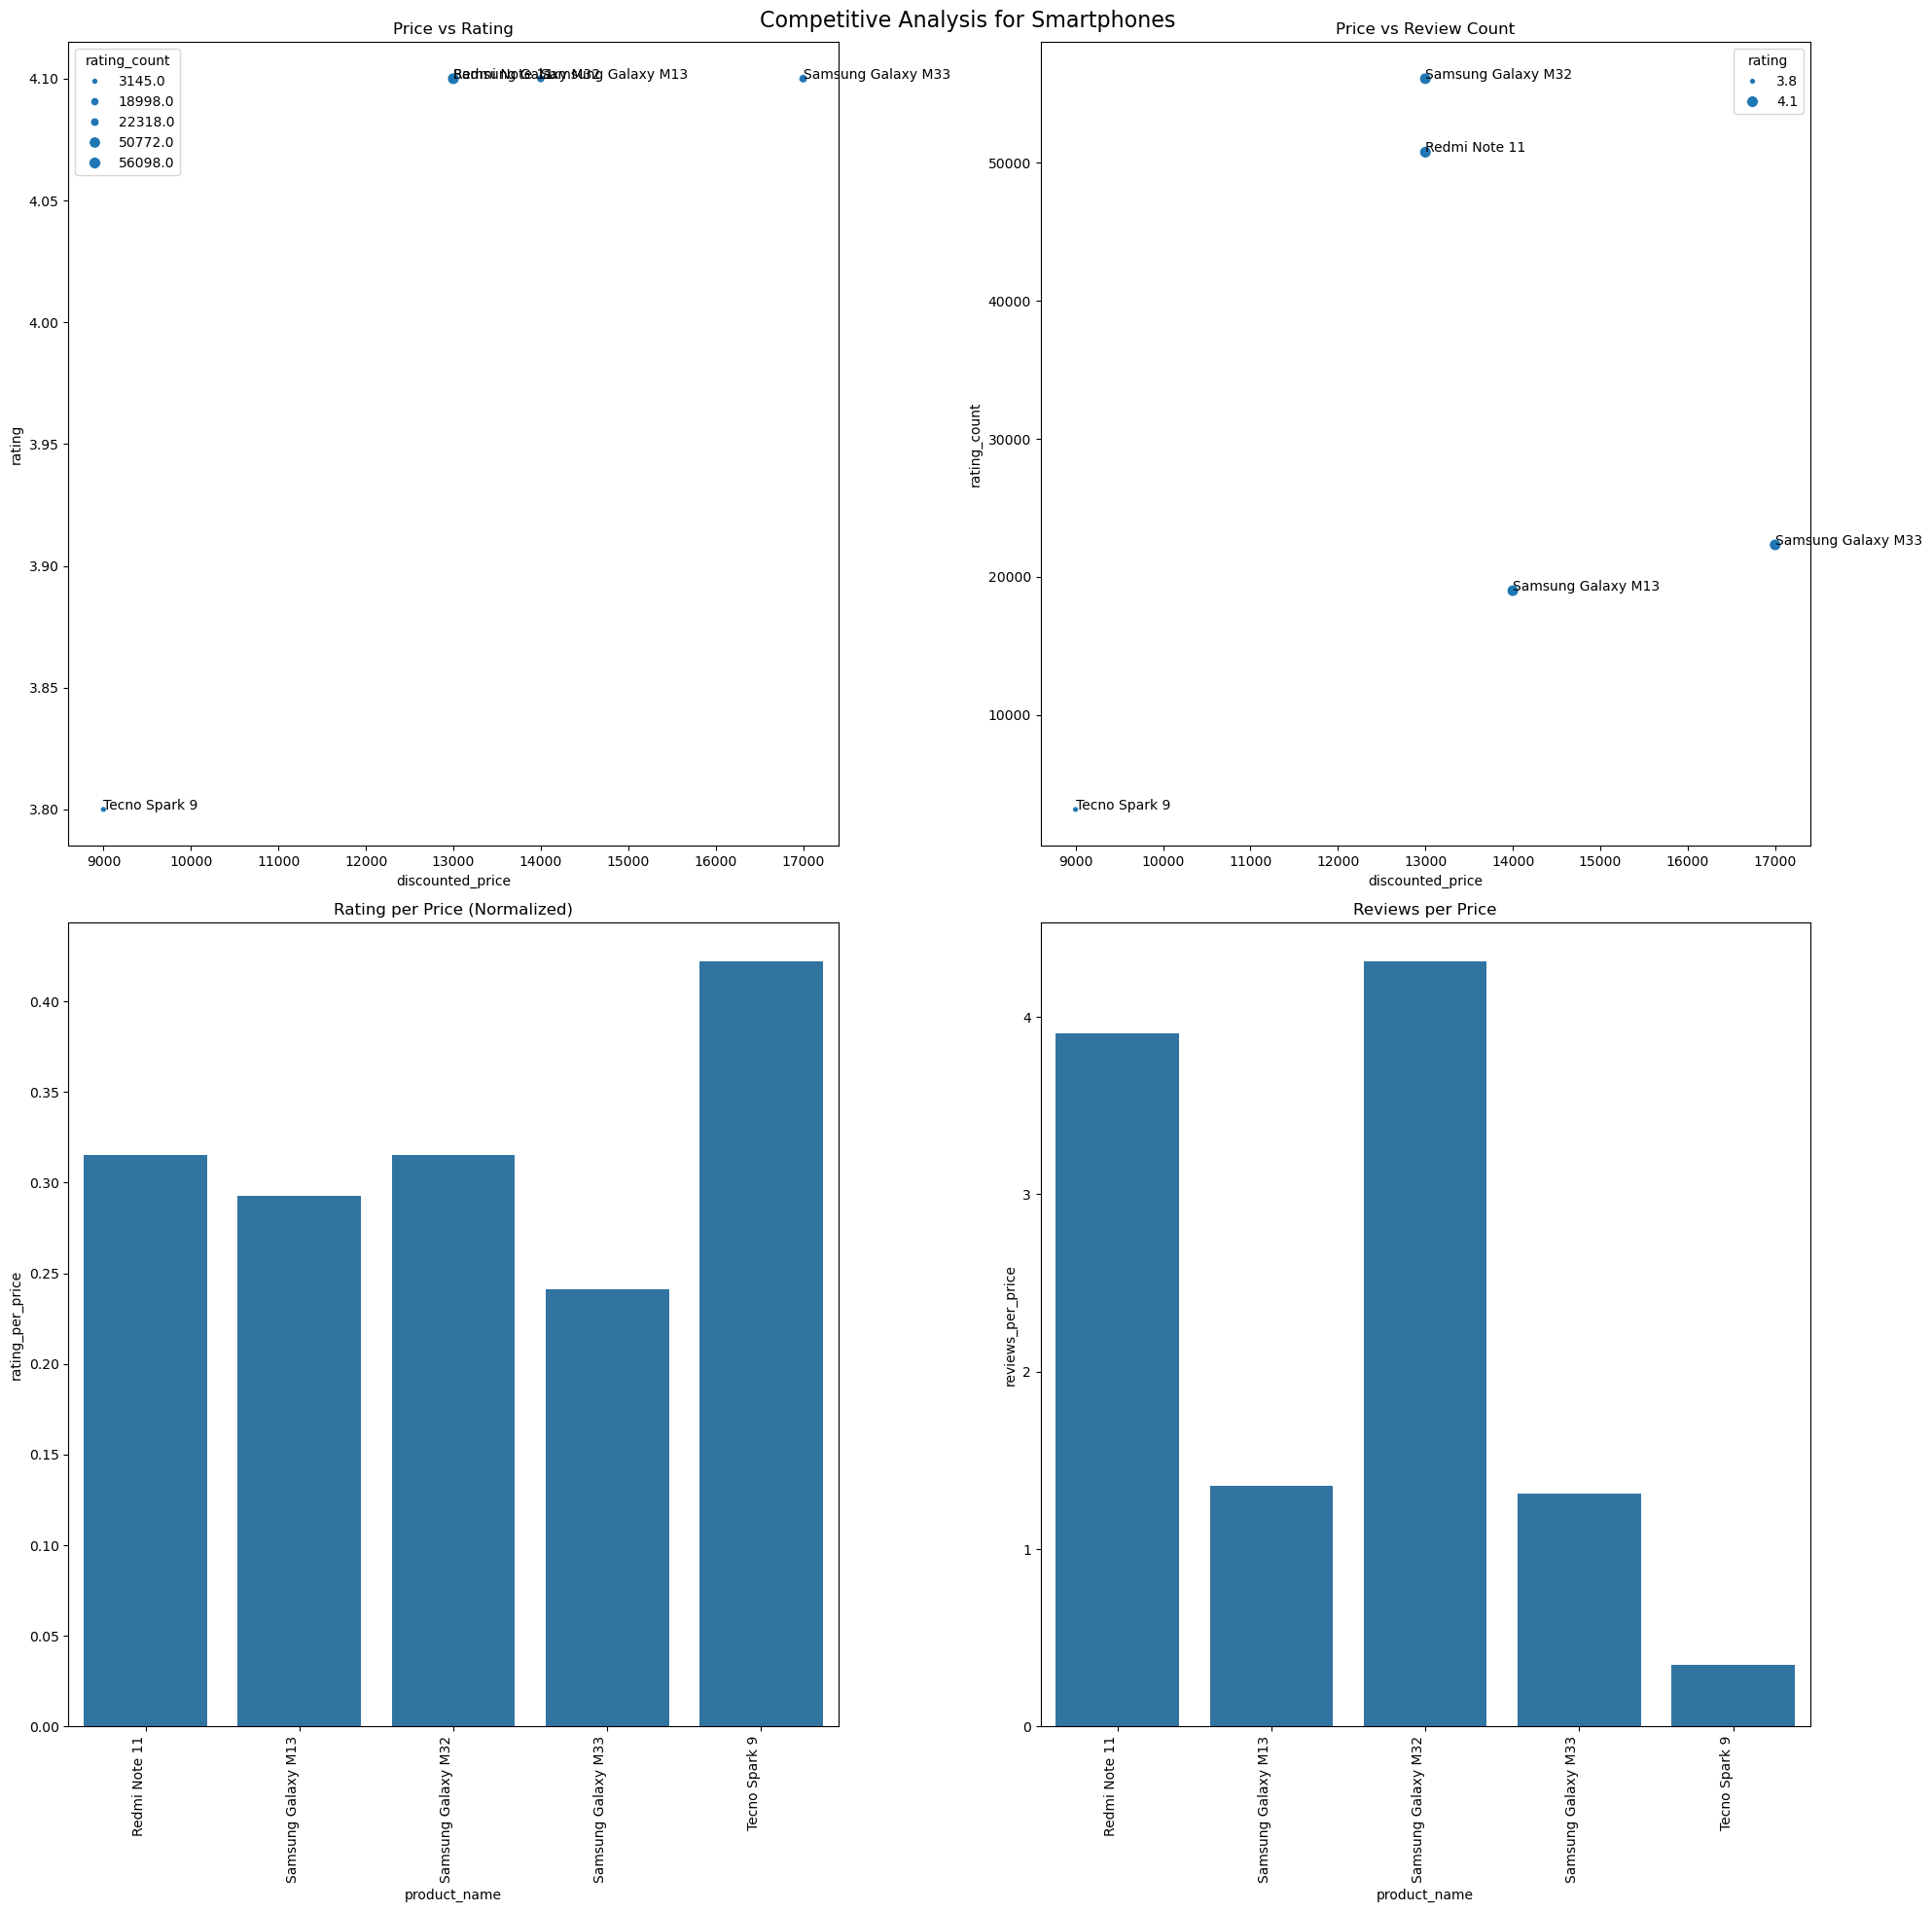

                    discounted_price  rating  rating_count  rating_per_price  \
product_name                                                                   
Redmi Note 11                12999.0     4.1       50772.0          0.315409   
Samsung Galaxy M13           13999.0     4.1       18998.0          0.292878   
Samsung Galaxy M32           12999.0     4.1       56098.0          0.315409   
Samsung Galaxy M33           16999.0     4.1       22318.0          0.241191   
Tecno Spark 9                 8999.0     3.8        3145.0          0.422269   

                    reviews_per_price  
product_name                           
Redmi Note 11                3.905839  
Samsung Galaxy M13           1.357097  
Samsung Galaxy M32           4.315563  
Samsung Galaxy M33           1.312901  
Tecno Spark 9                0.349483  


In [117]:
# 'Smartphones' 카테고리 분석
smartphone_analysis = analyze_competitive_products(df, 'Smartphones', 5)
print(smartphone_analysis)

### USB 케이블 카테고리 분석

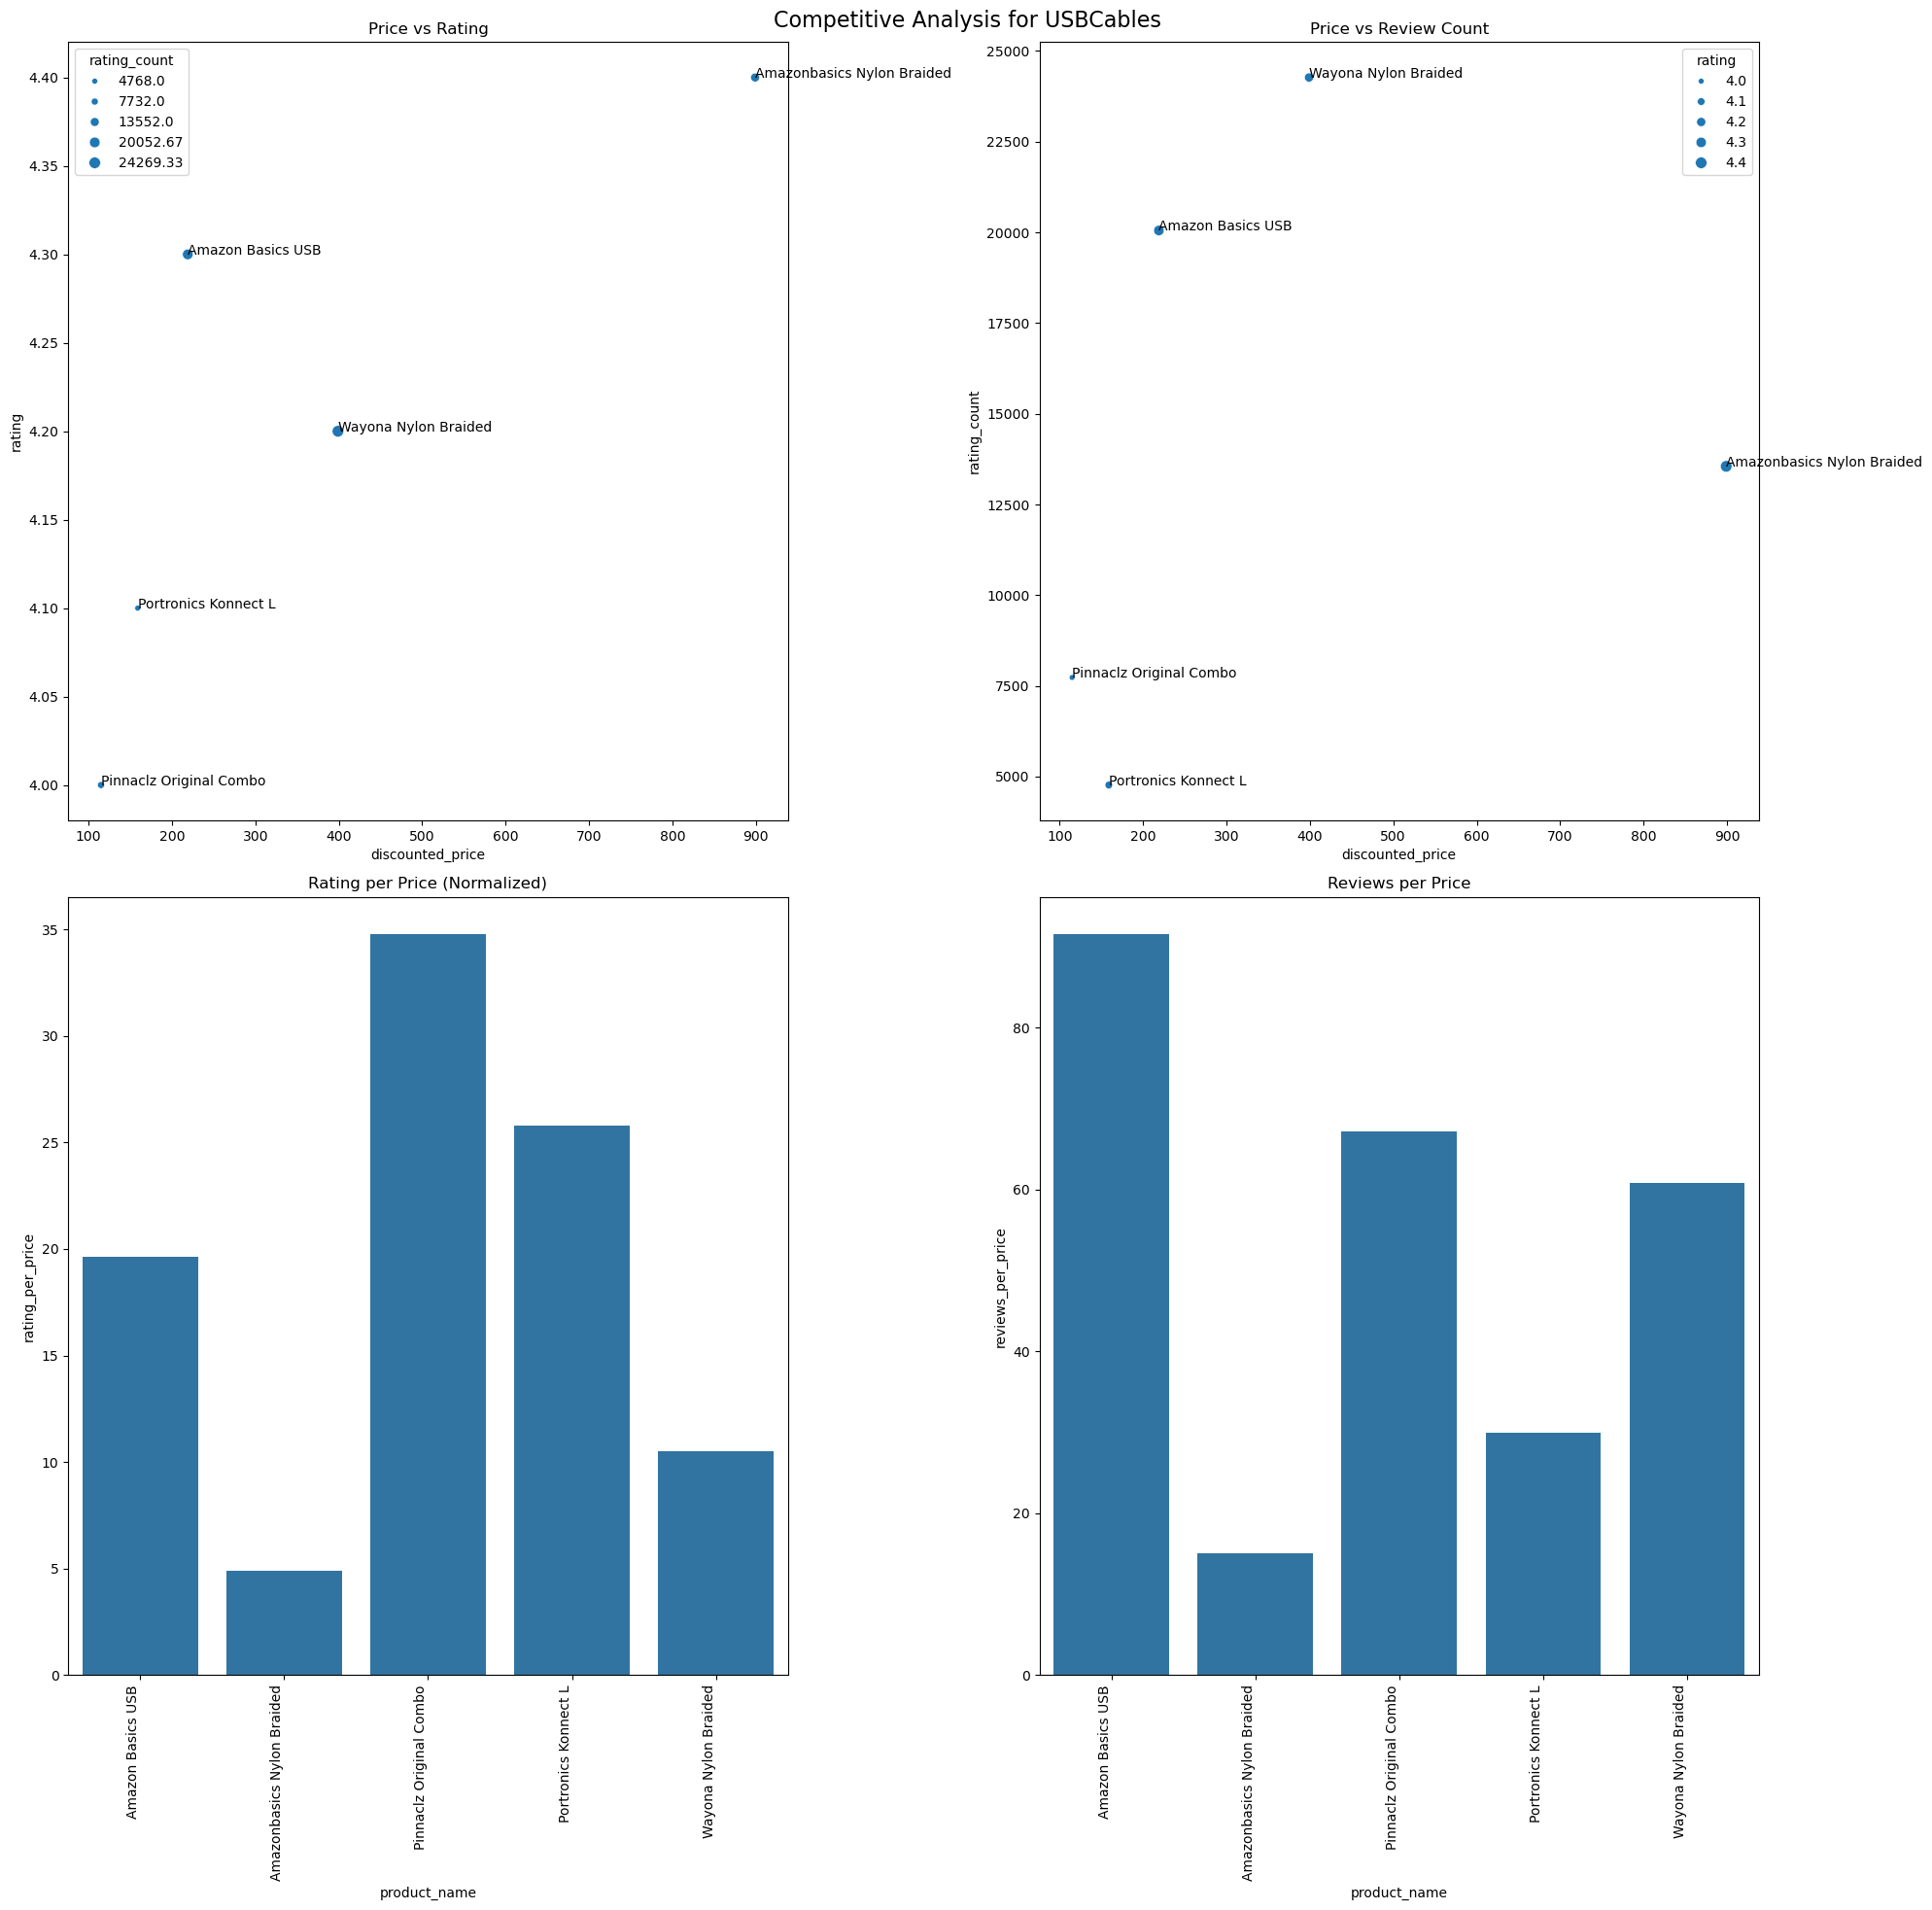

                            discounted_price  rating  rating_count  \
product_name                                                         
Amazon Basics USB                      219.0     4.3      20052.67   
Amazonbasics Nylon Braided             899.0     4.4      13552.00   
Pinnaclz Original Combo                115.0     4.0       7732.00   
Portronics Konnect L                   159.0     4.1       4768.00   
Wayona Nylon Braided                   399.0     4.2      24269.33   

                            rating_per_price  reviews_per_price  
product_name                                                     
Amazon Basics USB                  19.634703          91.564703  
Amazonbasics Nylon Braided          4.894327          15.074527  
Pinnaclz Original Combo            34.782609          67.234783  
Portronics Konnect L               25.786164          29.987421  
Wayona Nylon Braided               10.526316          60.825388  


In [119]:
# 'USBCables' 카테고리 분석
cables_analysis = analyze_competitive_products(df, 'USBCables', 5)
print(cables_analysis)

## 6. 이상치 분석
> 평균에서 <span style="color: #ffa500;">크게 벗어난</span> 가격이나 평점을 가진 제품들을 식별하고 그 원인 분석. 
> <span style="color: #ffa500;">특별히 성공적이거나 실패한</span> 제품의 특성 파악 가능.

In [132]:
def analyze_outliers(df, category):
    # 해당 카테고리의 데이터만 선택
    cat_data = df[df['big_category'] == category]
    cat_data['product_name'] = cat_data['product_name'].map(shorten_product_name)
    
    # Z-score를 이용한 이상치 탐지
    cat_data['price_zscore'] = sp.stats.zscore(cat_data['discounted_price'])
    cat_data['rating_zscore'] = sp.stats.zscore(cat_data['rating'])
    
    # 이상치 정의 (Z-score의 절대값이 3 이상)
    outliers = cat_data[(abs(cat_data['price_zscore']) > 3) | (abs(cat_data['rating_zscore']) > 3)]
    
    # 시각화
    plt.figure(figsize=(12, 8))
    plt.scatter(cat_data['discounted_price'], cat_data['rating'], alpha=0.5)
    plt.scatter(outliers['discounted_price'], outliers['rating'], color='red', alpha=0.7)
    plt.xlabel('Discounted Price')
    plt.ylabel('Rating')
    plt.title(f'Outliers in {category}')
    plt.xscale('log')  # 가격에 로그 스케일 적용
    
    for idx, row in outliers.iterrows():
        plt.annotate(row['product_name'], (row['discounted_price'], row['rating']))
    
    plt.show()
    
    # 상위 5개 이상치 제품 정보 출력
    print(f"Top 5 Outliers in {category}:")
    print(outliers.sort_values('price_zscore', key=abs, ascending=False)[['item', 'product_name', 'discounted_price', 'rating', 'rating_count']].head())
    
    # 성공적/실패한 제품 분석
    successful = cat_data[cat_data['rating'] > cat_data['rating'].mean() + cat_data['rating'].std()]
    unsuccessful = cat_data[cat_data['rating'] < cat_data['rating'].mean() - cat_data['rating'].std()]
    
    print("\nCharacteristics of Successful Products:")
    print(successful.groupby(['item', 'product_name']).agg({
        'discounted_price': 'mean',
        'rating': 'mean',
        'rating_count': 'mean'
    }).sort_values('rating', ascending=False).head())
    
    print("\nCharacteristics of Unsuccessful Products:")
    print(unsuccessful.groupby(['item', 'product_name']).agg({
        'discounted_price': 'mean',
        'rating': 'mean',
        'rating_count': 'mean'
    }).sort_values('rating').head())

### 전자제품 카테고리 분석

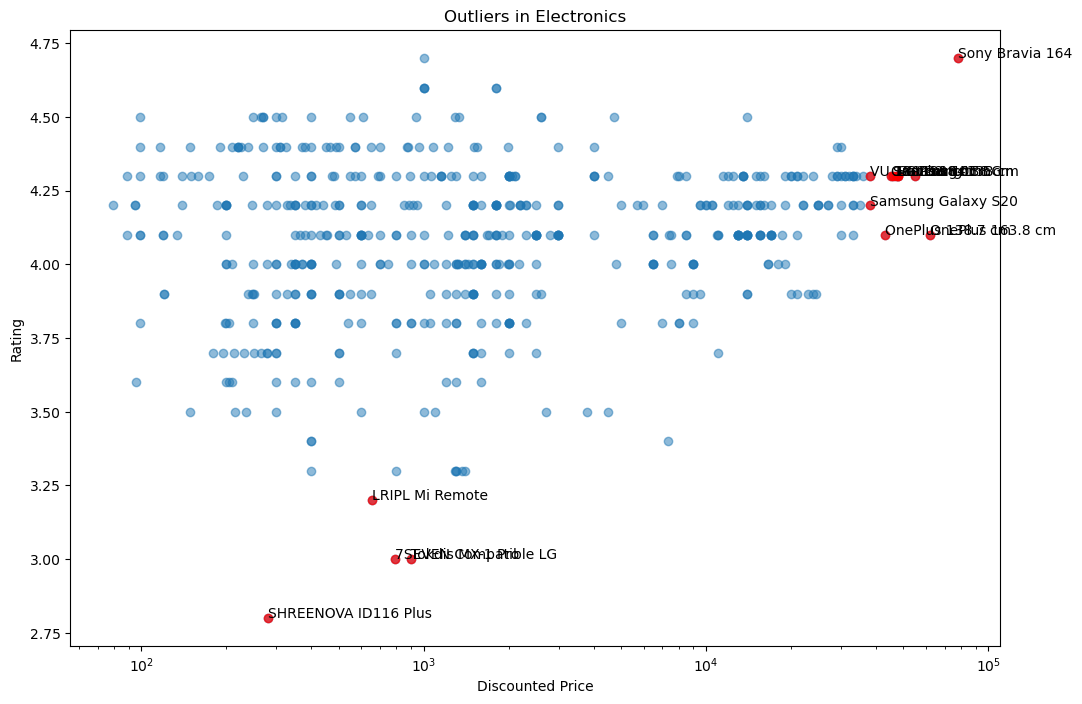

Top 5 Outliers in Electronics:
                 item      product_name  discounted_price  rating  \
249  SmartTelevisions   Sony Bravia 164           77990.0     4.7   
325  SmartTelevisions  OnePlus 163.8 cm           61999.0     4.1   
255  SmartTelevisions         VU 164 cm           54990.0     4.3   
192  SmartTelevisions    Samsung 138 cm           47990.0     4.3   
283  SmartTelevisions         LG 139 cm           47990.0     4.3   

     rating_count  
249        5935.0  
325        6753.0  
255        3587.0  
192        7109.0  
283        1376.0  

Characteristics of Successful Products:
                                  discounted_price    rating  rating_count
item             product_name                                             
SmartTelevisions Sony Bravia 164           77990.0  4.700000   5935.000000
ScreenProtectors Spigen EZ Fit               999.0  4.633333  13503.666667
SelfieSticks     WeCool S5 Long             1799.0  4.600000    245.000000
HDMICables       1

In [133]:
# 'Electronics' 대분류 분석
analyze_outliers(df, 'Electronics')

### '컴퓨터 및 주변 기기' 대분류 분석

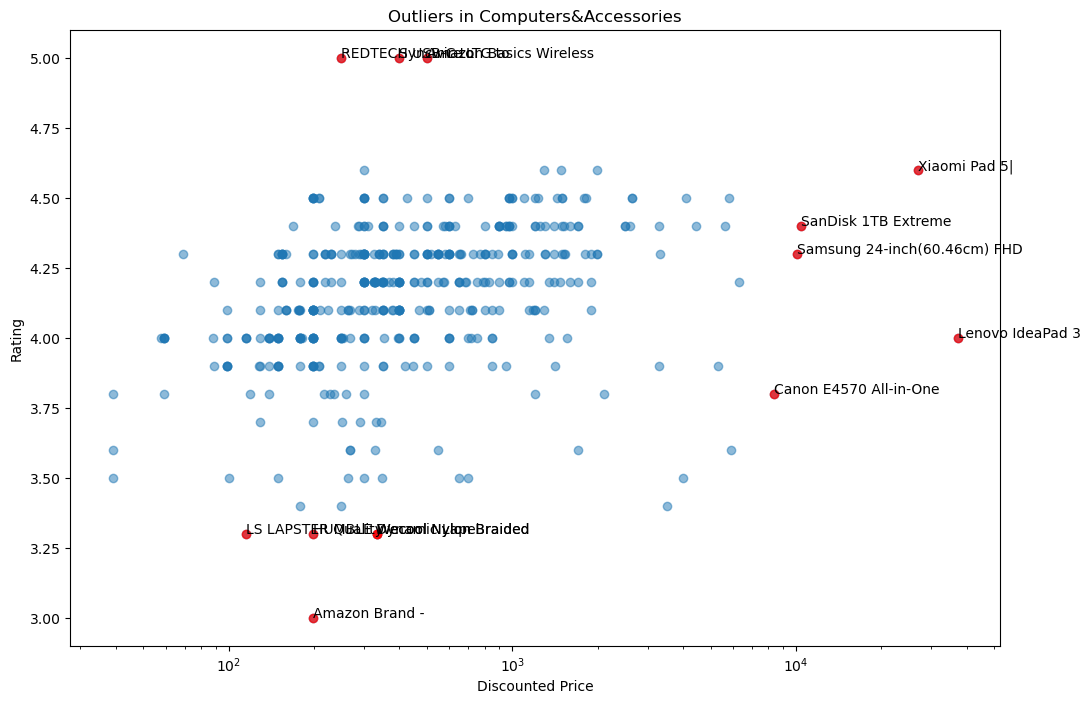

Top 5 Outliers in Computers&Accessories:
                          item                  product_name  \
1014        TraditionalLaptops              Lenovo IdeaPad 3   
976                    Tablets                 Xiaomi Pad 5|   
935   ExternalSolidStateDrives           SanDisk 1TB Extreme   
922                   Monitors  Samsung 24-inch(60.46cm) FHD   
1008            InkjetPrinters        Canon E4570 All-in-One   

      discounted_price  rating  rating_count  
1014           37247.0     4.0         323.0  
976            26999.0     4.6        2886.0  
935            10389.0     4.4       41398.0  
922            10099.0     4.3        2623.0  
1008            8349.0     3.8        3652.0  

Characteristics of Successful Products:
                                   discounted_price  rating  rating_count
item      product_name                                                   
Mice      Amazon Basics Wireless              499.0     5.0          23.0
USBCables Syncwire LTG to    

In [134]:
# 'Computers&Accessories' 대분류 분석
analyze_outliers(df, 'Computers&Accessories')

### '가전 제품' 대분류 분석

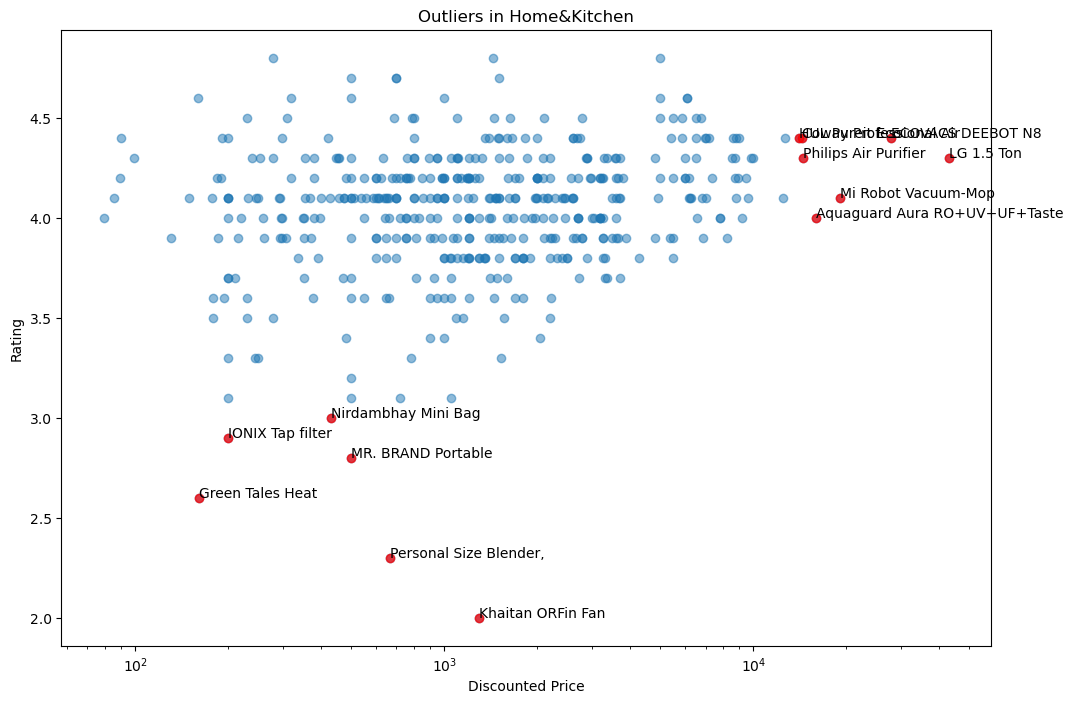

Top 5 Outliers in Home&Kitchen:
                             item                   product_name  \
1354  Split-SystemAirConditioners                     LG 1.5 Ton   
1306               RoboticVacuums              ECOVACS DEEBOT N8   
1430               RoboticVacuums            Mi Robot Vacuum-Mop   
1325       WaterFilters&Purifiers  Aquaguard Aura RO+UV+UF+Taste   
1234             HEPAAirPurifiers           Philips Air Purifier   

      discounted_price  rating  rating_count  
1354           42990.0     4.3        3231.0  
1306           27900.0     4.4        5298.0  
1430           18999.0     4.1        2536.0  
1325           15999.0     4.0       11206.0  
1234           14499.0     4.3        2026.0  

Characteristics of Successful Products:
                                              discounted_price  rating  \
item                product_name                                         
AirFryers           Instant Pot Air                     4995.0     4.8   
InstantWaterHe

In [135]:
# 'Home&Kitchen' 대분류 분석
analyze_outliers(df, 'Home&Kitchen')

## 7. 가격 탄력성 분석
> 할인율과 판매량(리뷰 수로 대체 가능) 간의 관계 분석. 
> 어떤 아이템이 가격 변화에 <span style="color: #ffa500;">민감하게 반응</span>하는지 파악.

#### 분석 결과 해석 시 주의할 점:
- 양수 탄력성: 가격이 오르면 리뷰 수(수요)가 감소함 (일상적인 소비재)
- 음수 탄력성: 가격이 오르면 리뷰 수(수요)가 증가함 (사치재, 럭셔리 상품 등에서 발생 가능)
- 높은 탄력성: 가격 변화에 민감한 제품 (|탄력성| > 1)
- 낮은 탄력성: 가격 변화에 덜 민감한 제품 (|탄력성| < 1)

#### 이 분석을 통해 얻을 수 있는 인사이트:
- 어떤 제품이 가격 변화에 민감한지 파악 가능
- 가격 정책 수립 시 참고 자료로 활용 가능
- 할인 프로모션의 효과성 예측에 도움이 됨

#### 단, 이 분석은 몇 가지 한계가 있음:
- 리뷰 수가 실제 판매량을 정확히 반영하지 않을 수 있음
- 시간에 따른 변화를 고려하지 않음 (데이터에 시간 정보가 있다면 이를 반영하여 개선 가능)
- 다른 요인들(마케팅, 경쟁사 제품 등)의 영향을 고려하지 않음
- 아마존에서 판매하는 '모든' 제품을 반영하지 않음

In [149]:
def analyze_price_elasticity(df, category):
    # 해당 카테고리의 데이터만 선택
    cat_data = df[df['big_category'] == category]
    
    # 아이템별로 그룹화
    grouped = cat_data.groupby('item')
    
    # 각 아이템의 가격 탄력성 계산
    elasticities = {}
    for name, group in grouped:
        if len(group) > 1:  # 최소 2개 이상의 데이터 포인트가 필요
            # 로그 변환을 통해 변화율 계산
            price_changes = np.diff(np.log(group['discounted_price']))
            review_changes = np.diff(np.log(group['rating_count']))
            
            # 0으로 나누는 경우를 방지
            valid_indices = (price_changes != 0)
            
            if np.any(valid_indices):
                # 탄력성 계산 (리뷰 수 변화 / 가격 변화)
                elasticity = np.mean(review_changes[valid_indices] / price_changes[valid_indices])
                
                # inf나 nan이 아닌 경우에만 결과에 포함
                if not np.isinf(elasticity) and not np.isnan(elasticity):
                    elasticities[name] = elasticity
    
    # 결과를 데이터프레임으로 변환
    elasticity_df = pd.DataFrame.from_dict(elasticities, orient='index', columns=['Elasticity'])
    elasticity_df = elasticity_df.sort_values('Elasticity', ascending=False)
    
    # # 시각화
    # plt.figure(figsize=(12, 6))
    # sns.barplot(x=elasticity_df.index, y='Elasticity', data=elasticity_df)
    # plt.title(f'Price Elasticity of Demand for {category}')
    # plt.xticks(rotation=90)
    # plt.xlabel('Product')
    # plt.ylabel('Elasticity')
    # plt.axhline(y=0, color='r', linestyle='--')
    # plt.tight_layout()
    # plt.show()

    # 시각화
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Elasticity', y=elasticity_df.index, data=elasticity_df)
    plt.title(f'Price Elasticity of Demand for {category}')
    plt.xticks(rotation=0)
    plt.xlabel('Elasticity')
    plt.ylabel('Product')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # 상위 5개 탄력적/비탄력적 아이템 출력
    print("Top 5 Elastic Items:")
    print(elasticity_df.head())
    print("\nTop 5 Inelastic Items:")
    print(elasticity_df.tail())

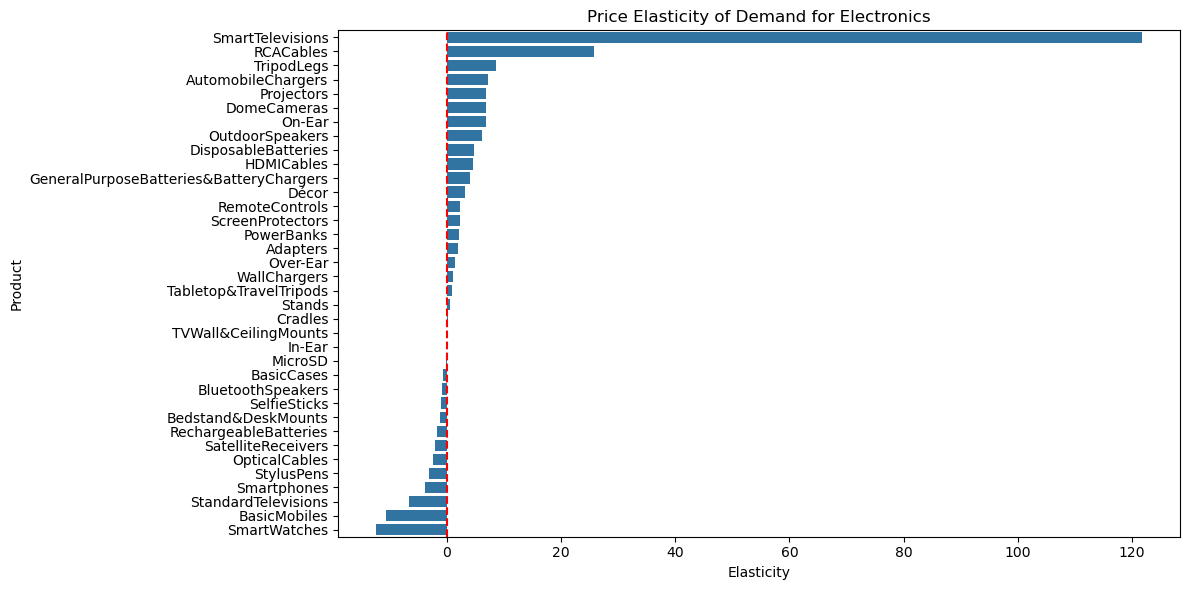

Top 5 Elastic Items:
                    Elasticity
SmartTelevisions    121.660341
RCACables            25.812253
TripodLegs            8.690470
AutomobileChargers    7.175620
Projectors            6.965657

Top 5 Inelastic Items:
                     Elasticity
StylusPens            -3.110227
Smartphones           -3.826123
StandardTelevisions   -6.496936
BasicMobiles         -10.555839
SmartWatches         -12.283548


In [150]:
# 'Electronics' 카테고리 분석
# 제품 종류 별 판매 중인 가짓수가 다를 수 있으며 현재 데이터 상으로는 1개만 판매해도 포함되어 있음 (향후 개선점)
analyze_price_elasticity(df, 'Electronics')

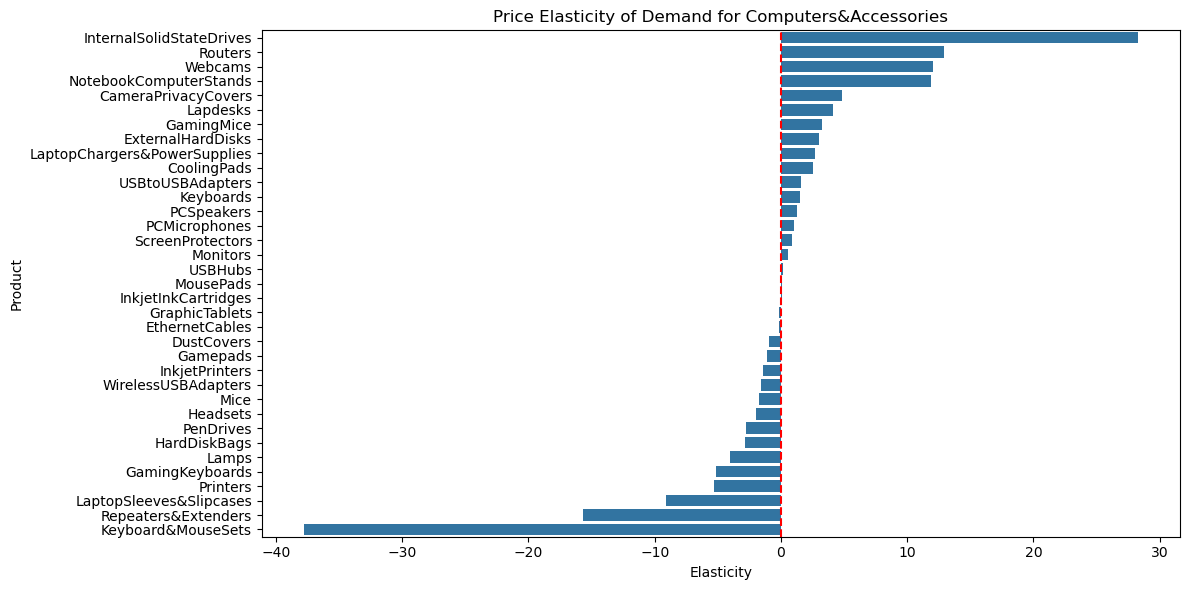

Top 5 Elastic Items:
                          Elasticity
InternalSolidStateDrives   28.304873
Routers                    12.897047
Webcams                    12.020018
NotebookComputerStands     11.903771
CameraPrivacyCovers         4.869960

Top 5 Inelastic Items:
                         Elasticity
GamingKeyboards           -5.171988
Printers                  -5.281279
LaptopSleeves&Slipcases   -9.078827
Repeaters&Extenders      -15.673657
Keyboard&MouseSets       -37.820731


In [152]:
# 'Computers&Accessories' 카테고리 분석
# 제품 종류 별 판매 중인 가짓수가 다를 수 있으며 현재 데이터 상으로는 1개만 판매해도 포함되어 있음 (향후 개선점)
analyze_price_elasticity(df, 'Computers&Accessories')

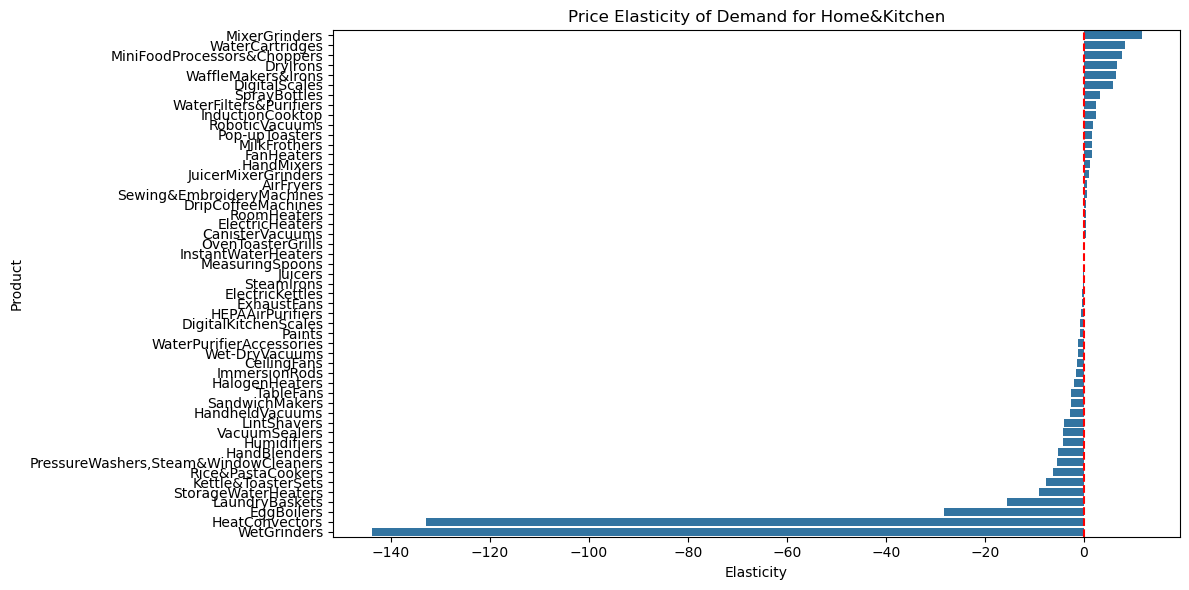

Top 5 Elastic Items:
                             Elasticity
MixerGrinders                 11.680819
WaterCartridges                8.291352
MiniFoodProcessors&Choppers    7.809929
DryIrons                       6.791436
WaffleMakers&Irons             6.591347

Top 5 Inelastic Items:
                     Elasticity
StorageWaterHeaters   -9.037871
LaundryBaskets       -15.561959
EggBoilers           -28.294332
HeatConvectors      -132.836195
WetGrinders         -143.881612


In [151]:
# 'Home&Kitchen' 카테고리 분석
# 제품 종류 별 판매 중인 가짓수가 다를 수 있으며 현재 데이터 상으로는 1개만 판매해도 포함되어 있음 (향후 개선점)
analyze_price_elasticity(df, 'Home&Kitchen')